# Dogs Vs. Cats: Training a Covnet from Scratch

In this notebook, I will explore the process of creating an image classification convolutional neural network (covnet) from scratch. 

Let's build the model with a series of `Conv2D` and `MaxPooling2D` layers. 

The data set used is the [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats) dataset from the 2013 Kaggle competiton. While the training dataset contains 25,000 training images, let's start with only a small fraction of that to save on computing costs for now. 

In [ ]:
import os
import shutil
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import matplotlib.pyplot as plt 

## Preparing the Dataset

Frist, download the data set from Kaggle using Terminal

Note: In Google Colab, we need to redownload the dataset when the runtime environment restarts. So I will include the terminal commands to download the dataset.

Reminder: Make sure to accept the competiton rules before downloading. Otherwise, you will get a `403 - Forbidden` error. 

In [ ]:
# In order to download from Kaggle, we need to provide our authenticaion JSON file. 

from google.colab import files
files.upload()

In [ ]:
# Create the directory that Kaggle checks for the authentication key, move the JSON file to the proper location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions on the key
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
# Download the dataset from Kaggle, then unzip it. 
!kaggle competitions download -c dogs-vs-cats
# Note that Google Colab uses an outdated Kaggle API (1.5.4) so the file downloaded is different.
!unzip -q train.zip
!rm train.zip

 96% 261M/271M [00:01<00:00, 187MB/s]
100% 271M/271M [00:01<00:00, 165MB/s]
 99% 540M/543M [00:02<00:00, 208MB/s]
100% 543M/543M [00:02<00:00, 192MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 132MB/s]


In [ ]:
# Move the dataset to its own directory
!mkdir dogs-vs-cats-data
!cp -r train dogs-vs-cats-data

### Preview some of the images

To get an idea of the images we are working with, lets preview some of the images. 




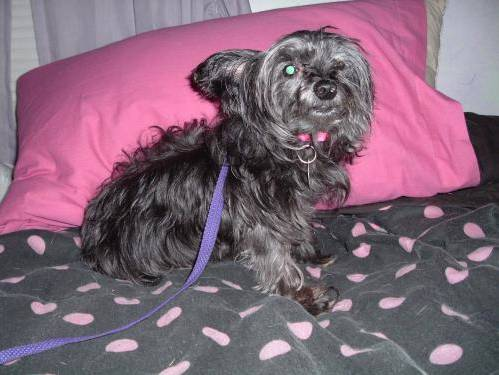

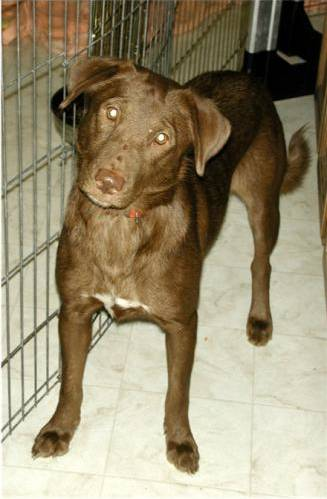

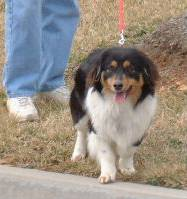

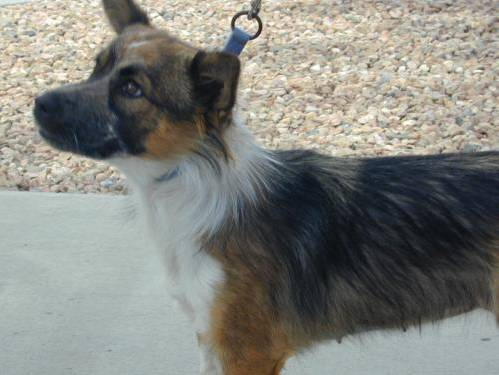

In [ ]:
from IPython.display import Image, display

# Display some Dogs
listOfImageNames = ['dogs-vs-cats-data/train/dog.0.jpg',
                    'dogs-vs-cats-data/train/dog.1.jpg',
                    'dogs-vs-cats-data/train/dog.2.jpg',
                    'dogs-vs-cats-data/train/dog.3.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

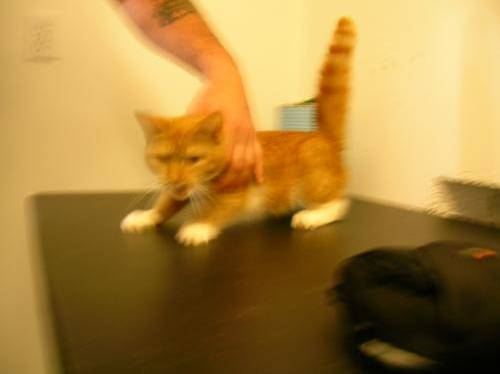

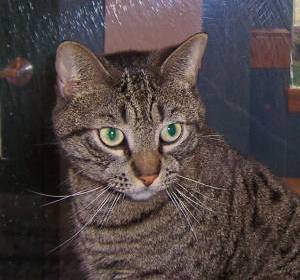

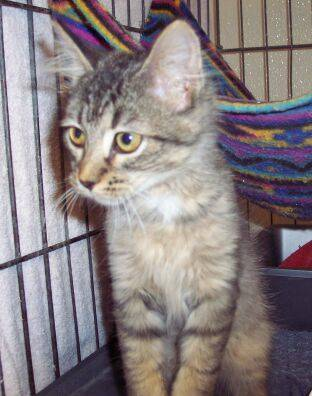

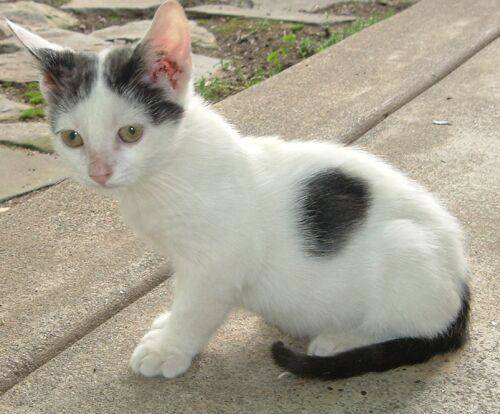

In [ ]:
# Display some Cats
listOfImageNames = ['dogs-vs-cats-data/train/cat.0.jpg',
                    'dogs-vs-cats-data/train/cat.1.jpg',
                    'dogs-vs-cats-data/train/cat.2.jpg',
                    'dogs-vs-cats-data/train/cat.3.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

By previewing the images, we can see that the images are in color, but they are not all the same size. This tells us that we will need a way to handle the different sizes before feeding it to our model. 

### Make a small dataset

Instead of the full 25,000 training images, let's use a small subset of that to practice on. 

This will also allow us to create separate training, validation, and testing sets. The original test data set does not have labels, so lets use the images from the training data set. 

Also, unfortuantly since the Kaggle competion is over, and there is no way to submit solutions, the test dataset is useless to us now, as there is no way to evaluate its accuracy (outside of manually labeling the images.)

In [ ]:
# Our full data set is in the original data folder. Let's make a new small folder.
original_dir = pathlib.Path('dogs-vs-cats-data')
new_base_dir = pathlib.Path('dogs-vs-cats-small')

# Define a function to move our images to the new directory.
def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
        # images in the train set have the file name dog.5.jpg, with no leading zeros. 
        fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
        for fname in fnames:
            # Copy from original_dir to new_base_dir
            shutil.copyfile(src=original_dir / "train"/ fname, dst=dir / fname)

# Define size of each set
# Select size/2 of each type of image to chose for the small subset. 
num_train_images = 2000
num_val_images = 1000
num_test_images = 2000

# Loop over the train, validation, and test sets, making subsets for each.
i = 0
for dataset, num_images in {"train":num_train_images, "validation":num_val_images, "test":num_test_images}.items():
    make_subset(dataset, i, int(i + num_images/2))
    i += int(num_images / 2)

## Construct the Model

Using Keras, let's build a covnet with a stack of alternated `Conv2d` and `MaxPooling2D` layers. 

Use an image input size of 180x180 pixels. 

With the following construction, we will end up with feature maps of size 7x7 just before the `Flatten` Layer

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
# Rescale color range from [0, 255] to [0, 1]
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

### Compile the model

For the loss, use `binary_crossentropy` since this is a binary classification problem. 

The metric we are interested in is accuracy. 

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Data Preprocessing

There are a few steps we need to take before we can feed the jpeg images into our model.

1. Read the picture files from the disk.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 x 180).
5. Pack them into batches (we’ll use batches of 32 images).

Let's use `keras.preprocessing` to help us with this. 

Calling `image_dataset_from_directory(directory)` will first list the subdirectories of `directory` and assume each one contains images from one of your class. It will then index the image files in each subdirectory. Finally, it will create and return a `tf.data.Dataset` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

By inferring the labels, we will assign a lable of `0` to cats and `1` to dogs.

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Dataset object 

Let’s look at the output of one of these Dataset objects: it yields batches of 180 × 180 RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model

Let's utilize a `ModelCheckpoint` callback to save the model after each epoch. We configure it with the path where to save the file, as well as the arguments `save_best_only=True` and `monitor='val_loss'`: they tell the callback to only save a new file (overwriting any previous one) when the current value of the `val_loss` metric is lower than at any previous time during training. This guarantees that the saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.



In [ ]:
import time
# Time the time it takes to train the model
start_time = time.time()

# Define the callback
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='models/convnet_from_scratch.keras',
    save_best_only=True,
    monitor='val_loss')]

# Fit the model
history = model.fit(
  train_dataset,
  epochs=20,
  validation_data=validation_dataset,
  callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/20
63/63 [==============================] - 41s 116ms/step - loss: 0.9454 - accuracy: 0.4831 - val_loss: 0.6907 - val_accuracy: 0.5110
Epoch 2/20
63/63 [==============================] - 6s 98ms/step - loss: 0.7021 - accuracy: 0.5620 - val_loss: 0.6698 - val_accuracy: 0.5770
Epoch 3/20
63/63 [==============================] - 7s 99ms/step - loss: 0.6782 - accuracy: 0.6029 - val_loss: 0.6600 - val_accuracy: 0.5980
Epoch 4/20
63/63 [==============================] - 7s 100ms/step - loss: 0.6488 - accuracy: 0.6320 - val_loss: 0.6203 - val_accuracy: 0.6510
Epoch 5/20
63/63 [==============================] - 7s 101ms/step - loss: 0.6008 - accuracy: 0.6781 - val_loss: 0.6066 - val_accuracy: 0.6530
Epoch 6/20
63/63 [==============================] - 7s 99ms/step - loss: 0.5583 - accuracy: 0.7085 - val_loss: 0.5950 - val_accuracy: 0.6980
Epoch 7/20
63/63 [==============================] - 7s 99ms/step - loss: 0.5595 - accuracy: 0.7400 - val_loss: 0.6650 - val_accuracy: 0.6170
Epoch 8/2

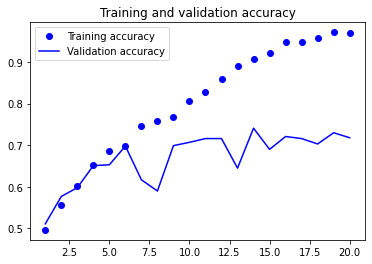

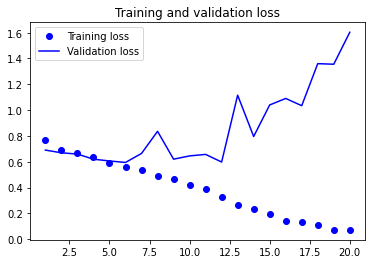

In [ ]:
# Plot the loss and accuracy of the model over the training and validation data during training. 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the test accuracy on the test dataset
test_model = keras.models.load_model('models/convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

63/63 [==============================] - 4s 54ms/step - loss: 0.5995 - accuracy: 0.6900
Test accuracy: 0.690


This simple covnet from scratch model trained on a small dataset produced an accuracy of about 71%. This is not that bad, beating our baseline of 50% accuracy. 

On the other hand, this model did take a very long time to train. Although, it was much faster on Google colab. 

## Using Data Augmentation

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by adding a number of data augmentation layers at the start of the model.

In [ ]:
data_augmentation = keras.Sequential(
    [
        # Randomly flip half of the images across the horizontal axis
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        # Randomly rotate every image by +/- 10% (or about +/- 36 degrees)
        layers.experimental.preprocessing.RandomRotation(0.1),
        # Randomly zoom every image in or out by about 20%
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

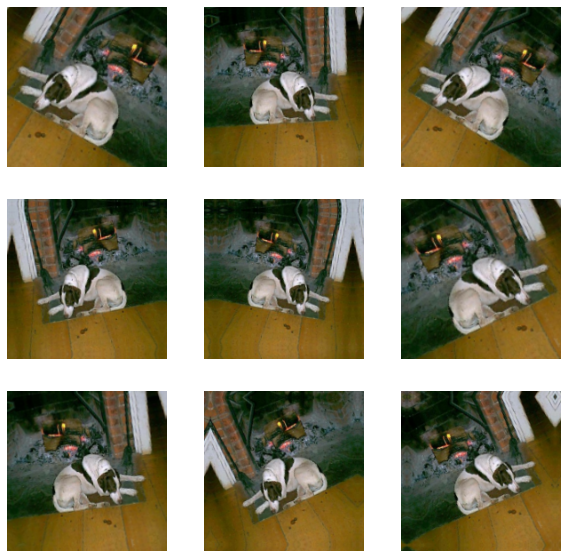

In [ ]:
# Preview some of the augmentations

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Retrain the model using the data augmentation and a dropout layer

All we have to do is add the data_augmentation layer right after the input. Then every image that is processed through the model will have an augmentation applied to it right away. 

We add a final dropout layer after the flatten layer.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.experimental.preprocessing.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# Define the callbacks. We can save the model with a different file name to compare later.
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='convnet_from_scratch_with_augmentation.keras',
    save_best_only=True,
    monitor='val_loss')]

start_time = time.time()

history = model.fit(
  train_dataset,
  epochs=80,
  validation_data=validation_dataset,
  verbose=2,
  callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/80
63/63 - 7s - loss: 0.7125 - accuracy: 0.5170 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/80
63/63 - 5s - loss: 0.7198 - accuracy: 0.5195 - val_loss: 0.6722 - val_accuracy: 0.5420
Epoch 3/80
63/63 - 5s - loss: 0.6876 - accuracy: 0.5590 - val_loss: 0.6699 - val_accuracy: 0.5090
Epoch 4/80
63/63 - 6s - loss: 0.6769 - accuracy: 0.6045 - val_loss: 0.8287 - val_accuracy: 0.5210
Epoch 5/80
63/63 - 5s - loss: 0.6969 - accuracy: 0.6265 - val_loss: 0.7117 - val_accuracy: 0.5550
Epoch 6/80
63/63 - 5s - loss: 0.6193 - accuracy: 0.6590 - val_loss: 0.6892 - val_accuracy: 0.6510
Epoch 7/80
63/63 - 5s - loss: 0.6175 - accuracy: 0.6695 - val_loss: 0.6084 - val_accuracy: 0.6540
Epoch 8/80
63/63 - 5s - loss: 0.6081 - accuracy: 0.6915 - val_loss: 0.8841 - val_accuracy: 0.5950
Epoch 9/80
63/63 - 5s - loss: 0.5798 - accuracy: 0.7010 - val_loss: 0.5657 - val_accuracy: 0.7080
Epoch 10/80
63/63 - 5s - loss: 0.5841 - accuracy: 0.7125 - val_loss: 0.5842 - val_accuracy: 0.6910
Epoch 11/80
63/63 -

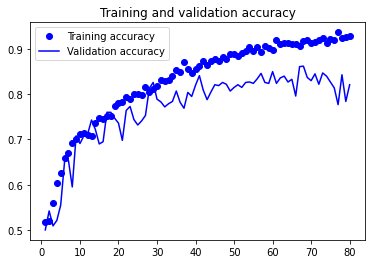

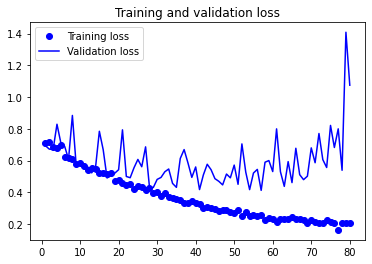

In [ ]:
# Plot the loss and accuracy of the model over the training and validation data during training. 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the new model on the test data
test_model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

63/63 [==============================] - 4s 53ms/step - loss: 0.4944 - accuracy: 0.8260
Test accuracy: 0.826


As we can see, adding a data augmentation and dropout layer significantly improved our accuracy. Both of these help mitigate overfitting, and have the result of increasing accuracy. 